Activities with >80% False motion_value:
PID: P06, Activity: FFSIT, Proportion of False: 1.00
PID: P11, Activity: FFSIT, Proportion of False: 0.96


/var/folders/xt/j055vd5n66x6nhkm2f0zzg2w0000gn/T/ipykernel_31507/3544266006.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=class_counts, palette=['skyblue', 'salmon'])


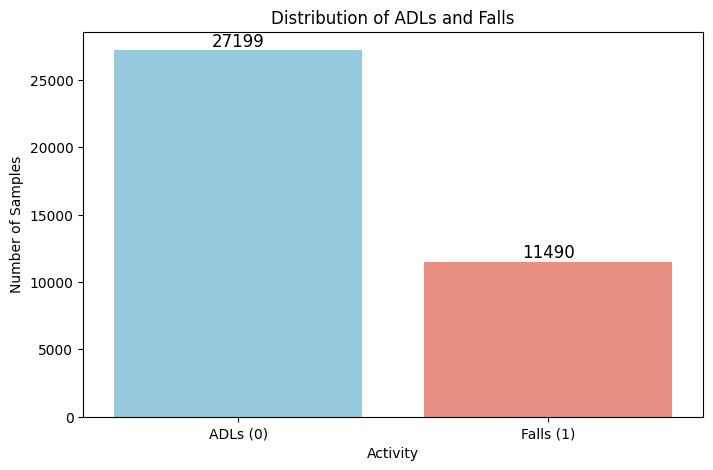

Index(['timestamp', 'motion_value', 'light', 'temp', 'breathingRate',
       'heartRate', 'physiologicalState', 'targetDistance_filtered',
       'health_idx', 'PID', 'activity_name', 'class', 'base_activity',
       'environmental_index'],
      dtype='object')


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, LSTM, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN


def plot_performance(history):
    # plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def remove_zero_readings(df, threshold=10):
    """Remove records with zero readings above threshold."""
    # Track problematic sensor combinations
    zero_readings = pd.DataFrame()
    for sensor in ['breathingRate', 'heartRate']:
        zero_counts = df[df[sensor] == 0.0].groupby(['PID', 'activity_name'])[sensor].count()
        zero_readings = pd.concat([zero_readings, zero_counts[zero_counts > threshold]])
    
    # Remove identified problematic records
    outlier_indices = zero_readings.index.drop_duplicates()
    return df[~df.set_index(['PID', 'activity_name']).index.isin(outlier_indices)]


df = pd.read_csv("combined_sensor_data-all-7.csv")


# remove redundant 
df = df.drop(['targetDistance', 'AbsolutePressure'], axis=1)

# feature engineering 
def combine_ambient(df, ambient_features):
    # Step 1: Select only ambient sensor features (CO2, Humidity, Noise, Pressure)
    ambient_df = df[ambient_features]

    # Step 2: Handle NaN values by filling with the mean
    ambient_df = ambient_df.fillna(ambient_df.mean())

    # Step 3: Standardize the ambient sensor features
    scaler = StandardScaler()
    ambient_features_scaled = scaler.fit_transform(ambient_df)
    # Step 4: Apply PCA to create the Environmental Index
    pca = PCA(n_components=1)  # Aggregate into a single component
    env_index = pca.fit_transform(ambient_features_scaled)
    # Add the Environmental Index to the original DataFrame
    df['environmental_index'] = env_index
    # Display the updated DataFrame
    # df.drop(ambient_features)
    # print(df.columns)
    df = df.drop(ambient_features, axis=1)
    return df


# Define the activities
fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]
non_fall_activities = ["LOB", "RS", "SBS", "SIT", "SSS", 'SSW', "SWW", "TWC", "WAT", 'WSS']
ambient_features = ['CO2', 'Humidity', 'Noise', 'Pressure']

def remove_low_motion_activities(df, threshold=0.8):
    """
    Print and remove fall activities where motion_value is False 
    for more than the threshold percentage of the activity's duration.
    """
    # List of fall activities to check
    fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]

    # Filter for fall activities only
    falls_df = df[df['activity_name'].isin(fall_activities)]

    # Calculate percentage of False motion values for each (PID, activity_name)
    motion_stats = (
        falls_df.groupby(['PID', 'activity_name'])['motion_value']
        .apply(lambda x: (x == False).mean())  # Calculate proportion of False values
    )

    # Identify activities to print and remove based on the threshold
    activities_to_remove = motion_stats[motion_stats > threshold]

    # Print the activity names and their proportions before removing
    print("Activities with >80% False motion_value:")
    for (pid, activity_name), proportion in activities_to_remove.items():
        print(f"PID: {pid}, Activity: {activity_name}, Proportion of False: {proportion:.2f}")

    # Remove identified activities from the DataFrame
    return df[~df.set_index(['PID', 'activity_name']).index.isin(activities_to_remove.index)]


# 2. Apply cleaning steps
df = remove_zero_readings(df)
df['motion_value'] = df['motion_value'].astype(int)
df = remove_low_motion_activities(df)

df_clean = df.drop(ambient_features, axis=1)
df_ambient = combine_ambient(df, ambient_features)

def filter_activities(df):
    # Define relevant fall activities
    fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]

    non_fall_activities = [
            "LOB", "RS", "SBS", 
            "SWW", "TWC", "WAT", 
            'WSS', 'SSW', 'SSS'
        ]

    # Filter the dataset to keep only relevant activities
    df_filtered = df[df['base_activity'].isin(fall_activities + non_fall_activities)]
    return df_filtered

final_df_clean = filter_activities(df_clean)
final_df_ambient = filter_activities(df_ambient)

def plot_class_distribution(df):
    """
    Plot the distribution of ADLs (class=0) and Falls (class=1) with sample counts.
    """
    # Get the class distribution
    class_counts = df['class'].value_counts().reset_index()
    class_counts.columns = ['class', 'count']
    class_counts['label'] = class_counts['class'].apply(lambda x: 'ADLs (0)' if x == 0 else 'Falls (1)')

    # Plot the distribution using a bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x='label', y='count', data=class_counts, palette=['skyblue', 'salmon'])

    # Add labels on top of the bars
    for index, row in class_counts.iterrows():
        plt.text(index, row['count'], f'{row["count"]}', ha='center', va='bottom', fontsize=12)

    # Add plot labels and title
    plt.title("Distribution of ADLs and Falls")
    plt.xlabel("Activity")
    plt.ylabel("Number of Samples")
    plt.show()

plot_class_distribution(df_clean)

# final_df
# 19195/10583
# print(len(final_df_clean.columns)) # 14 features
# print(final_df_clean.columns) # 14 features
print(final_df_ambient.columns) # 14 features
# print(df_clean.columns) # 14 features with all ADLs

# print(df_clean.shape)
# print(final_df_clean.shape)

# InceptionTime

In [12]:
# try 6 kernel size or 32 -> capture temporal dependencies 

class InceptionTime:
    def __init__(self, output_directory, input_shape, nb_classes, verbose=True, build=True, batch_size=64,
                 nb_filters=32, use_residual=True, use_bottleneck=True, depth=6, kernel_size=6, nb_epochs=100):

        self.output_directory = output_directory
        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs
        self.input_shape = input_shape
        self.nb_classes = nb_classes

        if build:
            self.model = self.build_model()
            if verbose:
                self.model.summary()

    def _inception_module(self, input_tensor, stride=1, activation='linear'):
        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        kernel_sizes = [self.kernel_size // (2 ** i) for i in range(3)]
        conv_list = []

        for kernel_size in kernel_sizes:
            conv = Conv1D(filters=self.nb_filters, kernel_size=kernel_size,
                          strides=stride, padding='same', activation=activation, use_bias=False)(input_inception)
            conv_list.append(conv)

        max_pool = MaxPooling1D(pool_size=3, strides=stride, padding='same')(input_tensor)
        conv_6 = Conv1D(filters=self.nb_filters, kernel_size=1,
                        padding='same', activation=activation, use_bias=False)(max_pool)
        conv_list.append(conv_6)

        x = Concatenate(axis=2)(conv_list)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                            padding='same', use_bias=False)(input_tensor)
        shortcut_y = BatchNormalization()(shortcut_y)
        x = Add()([shortcut_y, out_tensor])
        x = Activation('relu')(x)
        return x

    def build_model(self):
        input_layer = Input(self.input_shape)
        x = input_layer
        input_res = input_layer

        for d in range(self.depth):
            x = self._inception_module(x)
            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        gap_layer = GlobalAveragePooling1D()(x)
        output_layer = Dense(self.nb_classes, activation='sigmoid')(gap_layer)

        model = Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
        file_path = self.output_directory + 'best_model.keras'
        model_checkpoint = ModelCheckpoint(filepath=file_path, monitor='loss', save_best_only=True)
        self.callbacks = [reduce_lr, model_checkpoint]

        return model

    # def fit(self, x_train, y_train, x_val, y_val):
    #     if self.batch_size is None:
    #         mini_batch_size = int(min(x_train.shape[0] / 10, 16))
    #     else:
    #         mini_batch_size = self.batch_size

    #     hist = self.model.fit(
    #         x_train, y_train,
    #         batch_size=mini_batch_size,
    #         epochs=self.nb_epochs,
    #         verbose=1,
    #         validation_data=(x_val, y_val),
    #         callbacks=self.callbacks
    #     )

    #     return hist
    
    def fit(self, x_train, y_train, x_val, y_val):
        if self.batch_size is None:
            mini_batch_size = int(min(x_train.shape[0] / 10, 16))
        else:
            mini_batch_size = self.batch_size
        
        # Start time
        start_time = time.time()
        
        hist = self.model.fit(
            x_train, y_train,
            batch_size=mini_batch_size,
            epochs=self.nb_epochs,
            verbose=1,
            validation_data=(x_val, y_val),
            callbacks=self.callbacks
        )
        
        # End time
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")
        
        return hist

    def evaluate(self, x_test, y_test):
        """
        Evaluate the model on the test set.
        
        :param x_test: Test input data
        :param y_test: Test labels
        :return: Test loss and accuracy
        """
        return self.model.evaluate(x_test, y_test, batch_size=self.batch_size, verbose=1)

    def predict(self, X):
        """
        Make predictions using the trained model.
        
        :param X: Input data for prediction
        :return: Predicted probabilities
        """
        return self.model.predict(X, batch_size=self.batch_size)


# from tensorflow.keras.utils import to_categorical

def build_inceptiontime_model(input_shape):
    """
    Builds the InceptionTime model for binary classification.

    :param input_shape: Shape of the input data (e.g., (window_size, num_features))
    :return: Compiled InceptionTime model
    """
    inception_model = InceptionTime(
        output_directory='./',
        input_shape=input_shape,
        nb_classes=1, #binary classification
        verbose=0
    ).model
    # Compile the model with appropriate loss, optimizer, and metrics
    inception_model.compile(
        loss='binary_crossentropy', 
        optimizer='adam',
        metrics=['accuracy']
    )

    return inception_model

In [13]:
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from imblearn.over_sampling import ADASYN
from typing import Tuple
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, GlobalAveragePooling1D, Concatenate, BatchNormalization,
    Activation, Input, Dense, Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import numpy as np
from collections import Counter

# plt.style.use('classic')

def plot_advanced_metrics(y_test, y_pred_probs, model_name="CNN Model"):
    """
    Create publication-quality ROC and Precision-Recall curves
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_name} ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True)
    
    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    avg_precision = average_precision_score(y_test, y_pred_probs)
    
    ax2.plot(recall, precision, color='darkgreen', lw=2,
             label=f'PR curve (AP = {avg_precision:.3f})')
    ax2.axhline(y=np.sum(y_test)/len(y_test), color='navy', lw=2, linestyle='--',
                label='Random classifier')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_name} Precision-Recall Curve')
    ax2.legend(loc="lower left")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    # plt.tight_layout()
    # plt.savefig('advanced_metrics.png', dpi=300, bbox_inches='tight')
    # plt.close()
    
    return roc_auc, avg_precision

def analyze_threshold_impact(y_test, y_pred_probs):
    """
    Analyze impact of different classification thresholds using numpy operations
    """
    thresholds = np.arange(0.1, 1.0, 0.1)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_pred_probs >= threshold).astype(int)
        
        # Calculate confusion matrix elements using numpy
        tn = np.sum(np.logical_and(y_test == 0, y_pred == 0))
        fp = np.sum(np.logical_and(y_test == 0, y_pred == 1))
        fn = np.sum(np.logical_and(y_test == 1, y_pred == 0))
        tp = np.sum(np.logical_and(y_test == 1, y_pred == 1))
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    # Plot threshold impact
    plt.figure(figsize=(10, 6))
    thresholds = [r['threshold'] for r in results]
    plt.plot(thresholds, [r['precision'] for r in results], 
             label='Precision', marker='o')
    plt.plot(thresholds, [r['recall'] for r in results], 
             label='Recall', marker='s')
    plt.plot(thresholds, [r['f1'] for r in results], 
             label='F1-score', marker='^')
    plt.xlabel('Classification Threshold')
    plt.ylabel('Score')
    plt.title('Impact of Classification Threshold on Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results

def find_optimal_threshold(results):
    """Find threshold with highest F1 score"""
    return max(results, key=lambda x: x['f1'])['threshold']

def format_threshold_results(results):
    """Format threshold results as string"""
    text = ""
    for r in results:
        text += f"\n   Threshold {r['threshold']:.1f}:"
        text += f" Precision={r['precision']:.3f},"
        text += f" Recall={r['recall']:.3f},"
        text += f" F1={r['f1']:.3f}"
    return text

def evaluate_model_advanced(model, X_test, y_test):
    """
    Main function to generate all advanced metrics
    """
    # Get predictions and ensure they're the right shape
    y_pred_probs = model.predict(X_test, verbose=0)
    if len(y_pred_probs.shape) > 1 and y_pred_probs.shape[1] == 1:
        y_pred_probs = y_pred_probs.ravel()
    
    # Generate ROC and PR curves
    roc_auc, avg_precision = plot_advanced_metrics(y_test, y_pred_probs)
    
    # Analyze threshold impact
    threshold_results = analyze_threshold_impact(y_test, y_pred_probs)
    
    # Generate summary
    summary = f"""
    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): {roc_auc:.4f}

    2. Precision-Recall Analysis:
    - Average Precision (AP): {avg_precision:.4f}

    3. Threshold Analysis:
    Optimal threshold based on F1-score: {find_optimal_threshold(threshold_results):.2f}
    
    Performance at different thresholds:
    {format_threshold_results(threshold_results)}
    """
    
    print(summary)
    return roc_auc, avg_precision, threshold_results


# def create_sliding_windows(data, window_size=8, step_size=1):
#     """Create sliding windows within each activity, ensuring activities are not mixed."""
#     windows = []
#     labels = []

#     # Extract feature columns and ensure they are numeric
#     features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)
#     # features_df = features_df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coercing errors to NaN
#     # features_df = features_df.fillna(0)

#     print(features_df) 
#     # Group by participant and activity to maintain boundaries
#     for _, group in data.groupby(['PID', 'activity_name']):
#         group = group.reset_index(drop=True)

#         # Handle any NaN values resulting from coercion
#         group = group.fillna(0)  # Replace NaN values with 0 or use other imputation methods

#         for i in range(0, len(group) - window_size + 1, step_size):
#             window = group.iloc[i:i + window_size]

#             # Normalize the window
#             normalized_window = normalize_window(window[features_df.columns].values)

#             windows.append(normalized_window)
#             labels.append(window['class'].mode()[0])  # Assign the most frequent class in the window

#     return np.array(windows), np.array(labels)


# new
def create_sliding_windows2(data, window_size=11, step_size=1):
    """Create sliding windows within each activity, ensuring activities are not mixed."""
    windows = []
    labels = []

    # Extract feature columns and ensure they are numeric
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)

    # Group by participant and activity to maintain boundaries
    for _, group in data.groupby(['PID', 'activity_name']):
        group = group.reset_index(drop=True)

        # Handle any NaN values resulting from coercion
        # group = group.fillna(0)  # Replace NaN values with 0 or use other imputation methods

        # Only process windows of the desired size
        for i in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[i:i + window_size]

            # Normalize the window
            normalized_window = normalize_window(window[features_df.columns].values)

            windows.append(normalized_window)
            labels.append(window['class'].mode()[0])  # Assign the most frequent class in the window
    return np.array(windows), np.array(labels)


def normalize_window(window):
    """Normalize each sliding window independently (channel-wise)."""
    epsilon = 1e-10  # To prevent division by zero
    mean = window.mean(axis=0)  # Mean per feature
    std = window.std(axis=0)  # Std per feature
    return (window - mean) / (std + epsilon)


def apply_ros(X_train, y_train):
    """
    Apply Random OverSampling (ROS) to balance the dataset.
    """
    ros = RandomOverSampler(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape for ROS
    X_resampled, y_resampled = ros.fit_resample(X_train_reshaped, y_train)
    print(f"Data after ROS: {X_resampled.shape[0]} samples")
    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, y_train)
    print(f"Data after SMOTE: {X_resampled.shape[0]} samples")

    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

def apply_adasyn(X_train, y_train):
    adasyn = ADASYN(random_state=42)
    # Reshape the data for ADASYN (flatten each sample into 2D for the algorithm)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_resampled, y_resampled = adasyn.fit_resample(X_train_reshaped, y_train)
    
    print(f"Data after ADASYN: {X_resampled.shape[0]} samples")
    
    # Reshape back to the original shape of X_train
    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled


def apply_mu_sigma(X_train: np.ndarray, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Augments training data using Mu-Sigma augmentation technique.
    Doubles the training data by creating synthetic signals with added/subtracted noise.
    
    Args:
        X_train (np.ndarray): Training data of shape (n_samples, n_timesteps[, n_features])
        y_train (np.ndarray): Training labels
        
    Returns:
        Tuple[np.ndarray, np.ndarray]: Augmented training data and corresponding labels
    """
    # Generate noise for each sample in training data
    noise = np.zeros_like(X_train)
    
    # Calculate noise for each sample independently
    for i in range(len(X_train)):
        # Calculate sd of current sample
        sigma = np.std(X_train[i])
        # Generate noise with zero mean and sample's sd
        noise[i] = np.random.normal(loc=0, scale=sigma, size=X_train[i].shape)
    
    # Create augmented samples
    X_plus_noise = X_train + noise
    X_minus_noise = X_train - noise
    
    # Combine original and augmented data
    X_augmented = np.vstack((X_train, X_plus_noise, X_minus_noise))
    y_augmented = np.concatenate((y_train, y_train, y_train))
    
    # shuffle the augmented dataset
    shuffle_idx = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[shuffle_idx]
    y_augmented = y_augmented[shuffle_idx]
    
    return X_augmented, y_augmented


def apply_gan_augmentation(X_train, y_train, num_samples=100, noise_dim=100, hidden_dim=64, num_epochs=500):
    """
    Generate synthetic time-series data using a GAN and augment the training set.
    
    Parameters:
    - X_train: Original training data (features)
    - y_train: Original training labels
    - num_samples: Number of synthetic sequences to generate
    - noise_dim: Dimensionality of the random noise vector
    - hidden_dim: Hidden layer size for both Generator and Discriminator
    - num_epochs: Number of epochs to train the GAN
    
    Returns:
    - X_augmented: Augmented feature set (X_train + synthetic samples)
    - y_augmented: Augmented labels set (y_train + synthetic labels)
    """

    # Get sequence length from X_train (assume [n_samples, seq_len, features])
    seq_len = X_train.shape[1]
    feature_dim = X_train.shape[2]

    # Define Generator
    class Generator(nn.Module):
        def __init__(self, noise_dim, hidden_dim, output_dim):
            super(Generator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(noise_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )

        def forward(self, noise):
            return self.model(noise)

    # Define Discriminator
    class Discriminator(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Discriminator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim, 1),
                nn.Sigmoid()
            )

        def forward(self, data):
            return self.model(data)

    # Initialize the Generator and Discriminator
    generator = Generator(noise_dim, hidden_dim, seq_len * feature_dim)
    discriminator = Discriminator(seq_len * feature_dim, hidden_dim)

    # Optimizers and loss function
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    # Function to generate random noise
    def generate_noise(batch_size, noise_dim):
        return torch.randn(batch_size, noise_dim)

    # Train the GAN
    batch_size = 32
    for epoch in range(num_epochs):
        # === Train Discriminator ===
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = torch.tensor(X_train[idx].reshape(batch_size, -1), dtype=torch.float32)
        fake_data = generator(generate_noise(batch_size, noise_dim)).detach()

        # Discriminator loss
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        d_loss_real = criterion(discriminator(real_data), real_labels)
        d_loss_fake = criterion(discriminator(fake_data), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Backprop for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        noise = generate_noise(batch_size, noise_dim)
        generated_data = generator(noise)

        g_loss = criterion(discriminator(generated_data), real_labels)  # Fool the discriminator

        # Backprop for Generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Generate synthetic data
    noise = generate_noise(num_samples, noise_dim)
    synthetic_data = generator(noise).detach().numpy()
    synthetic_data = synthetic_data.reshape(num_samples, seq_len, feature_dim)

    # Create synthetic labels (1 for falls or any minority class, as needed)
    synthetic_labels = np.ones(num_samples)

    # Concatenate synthetic data with original training data
    X_augmented = np.concatenate((X_train, synthetic_data), axis=0)
    y_augmented = np.concatenate((y_train, synthetic_labels), axis=0)

    return X_augmented, y_augmented


def weighted_binary_crossentropy(weight_for_1):
    """
    Custom weighted binary cross-entropy loss.
    weight_for_1: Weight for positive class (falls, class = 1).
    """
    def loss_fn(y_true, y_pred):
        # Compute the standard binary cross-entropy loss
        bce = K.binary_crossentropy(y_true, y_pred)

        # Apply weights: higher weight for class 1 (falls)
        weight_vector = y_true * weight_for_1 + (1. - y_true) * 1.0  # Class 0 gets weight 1.0

        # Return the weighted loss
        return K.mean(weight_vector * bce)

    return loss_fn


def print_window_dataset_info(X, y, stage=""):
    """
    Print detailed information about windowed dataset
    """
    print(f"\n{'='*20} {stage} {'='*20}")
    print(f"Dataset shape: {X.shape}")  # (n_samples, window_size, n_features)
    print(f"Labels shape: {y.shape}")   # (n_samples,)
    
    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    
    print("\nClass Distribution:")
    print("-----------------")
    for class_label, count in zip(unique, counts):
        percentage = (count / total_samples) * 100
        print(f"Class {class_label}: {count} samples ({percentage:.2f}%)")


def get_all_metrics(model, X_test, y_test, model_name, threshold=0.5):  # made threshold a parameter
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > threshold).astype(int)  # use the threshold parameter
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    sensitivity = recall_score(y_test, y_pred) # Sensitivity (Recall)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"######## Confusion matrix for {model_name} model (threshold={threshold}) ########")
    print(f"Sensitivity (Recall): {sensitivity*100:.4f}%")
    print(f"Specificity: {specificity*100:.4f}%")
    print(f"Precision: {precision*100:.4f}%")
    print(f"Test Accuracy: {accuracy*100:.4f}%")
    print(f"F1 Score: {f1*100:.4f}%")
    print("################################################")
    
    metrics = {
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1
    }
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return metrics


def group_kfold_model_performance(data, build_model_fn=None, augmentation_fn=None, window_size=11, step_size=1, n_splits=5, epochs=100):
    # Generate sliding windows and labels, now also keeping track of PIDs
    windows, labels = create_sliding_windows2(data, window_size=window_size, step_size=step_size)
    pids = []
    for _, group in data.groupby(['PID', 'activity_name']):
        pid = group['PID'].iloc[0]
        n_windows = len(group) - window_size + 1
        pids.extend([pid] * n_windows)
    pids = np.array(pids)
    
    # First split maintaining group structure
    unique_pids = np.unique(pids)
    # Using GroupShuffleSplit for train/test split to maintain participant separation
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(windows, labels, groups=pids))
    
    X_train, X_test = windows[train_idx], windows[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    pids_train, pids_test = pids[train_idx], pids[test_idx]
    
    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    print(f"Training participants: {len(np.unique(pids_train))}, Test participants: {len(np.unique(pids_test))}")
    
    print_window_dataset_info(X_train, y_train, "Training Set Before Augmentation")

    # Apply augmentation if specified
    if augmentation_fn:
        X_train_resampled, y_train_resampled = augmentation_fn(X_train, y_train)
        # Replicate the PIDs after augmentation to match the new samples
        # pids_train_resampled = np.repeat(pids_train, len(X_train_resampled) // len(X_train))
        unique_pids = np.unique(pids_train)
        augmented_size = len(X_train_resampled)
        pids_per_class = {
            label: pids_train[y_train == label] for label in np.unique(y_train)
        }
        pids_train_resampled = []
        for label in np.unique(y_train_resampled):
            label_count = np.sum(y_train_resampled == label)
            label_pids = np.tile(pids_per_class[label], 
                               int(np.ceil(label_count / len(pids_per_class[label]))))
            pids_train_resampled.extend(label_pids[:label_count])
        pids_train_resampled = np.array(pids_train_resampled)
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
        pids_train_resampled = pids_train
    
    print_window_dataset_info(X_train_resampled, y_train_resampled, 
                            f"Training Set After {augmentation_fn.__name__ if augmentation_fn else 'No'} Augmentation")
    assert len(X_train_resampled) == len(y_train_resampled) == len(pids_train_resampled), "Mismatch in lengths after augmentation"
    
    # GroupKFold cross-validation
    group_kfold = GroupKFold(n_splits=n_splits)
    cv_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    test_metrics = None
    best_model = None
    best_val_score = 0
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_resampled, 
                                                                 y_train_resampled, 
                                                                 groups=pids_train_resampled)):
        print(f"\nFold {fold + 1}/{n_splits}")
        print(f"Validation participants: {np.unique(pids_train_resampled[val_idx])}")
        
        X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
        y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

        input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])
        model = build_model_fn(input_shape=input_shape)
        
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=32,
            verbose=1
        )
        
        y_val_pred = (model.predict(X_fold_val) > 0.5).astype(int)
        val_acc = accuracy_score(y_fold_val, y_val_pred)
        
        cv_scores['accuracy'].append(val_acc)
        cv_scores['precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_scores['recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_scores['f1'].append(f1_score(y_fold_val, y_val_pred))
        
        if val_acc > best_val_score:
            best_val_score = val_acc
            best_model = model
            
        print(f"Fold {fold + 1} validation accuracy: {val_acc:.4f}")
    
    # Evaluate best model on test set
    roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
    thres = find_optimal_threshold(threshold_results)

    y_test_pred = (best_model.predict(X_test) > thres).astype(int)
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred)
    }
    
    print("\nCross-Validation Results:")
    for metric in cv_scores:
        mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
        print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")
    
    print("\nTest Set Results (Best Model):")
    for metric, value in test_metrics.items():
        print(f"{metric.title()}: {value:.4f}")
    
    print("\nTest Set Participants:", np.unique(pids_test))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    return cv_scores, test_metrics, best_model, history


# augmentation_fn -> mu-sigma
# second_aug_fn -> smote/ros/adasyn
def kfold_model_performance(data, build_model_fn=None, augmentation_fn=None, second_aug_fn=None, gan_fn=None, window_size=11, step_size=1, n_splits=5, epochs=100):
  
    # Preprocess data
    # Step 2: Generate sliding windows and labels
    windows, labels = create_sliding_windows2(data, window_size=window_size, step_size=step_size)
    print("stratify labels")
    # print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    X_train, X_test, y_train, y_test = train_test_split(
        windows, labels, test_size=0.2, random_state=42, stratify=labels
    )
    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    print_window_dataset_info(X_train, y_train, "Training Set Before Augmentation")

    # Step 4: Apply oversampling (ROS or SMOTE) on the training data only 
    if augmentation_fn:
        X_train_resampled, y_train_resampled = augmentation_fn(X_train, y_train)
        desc = f"Training Set After {augmentation_fn.__name__}"
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
        desc = "Training set: NO Sampling"
        
    if second_aug_fn:
        X_train_resampled, y_train_resampled = second_aug_fn(X_train_resampled, y_train_resampled)
        desc =  f"Training Set After {second_aug_fn.__name__}"
    
    if gan_fn:
        X_train_resampled, y_train_resampled = apply_gan_augmentation(X_train_resampled, y_train_resampled)
        desc =  f"Training Set After GAN: {gan_fn.__name__}"
        
    print_window_dataset_info(X_train_resampled, y_train_resampled, desc)
    
    # Stratified k-fold cross-validation
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    test_metrics = None
    best_model = None
    best_val_score = 0
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_resampled, y_train_resampled)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
        y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

        # Step 5: Build and compile the 1D CNN model
        input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])
        model = build_model_fn(input_shape=input_shape)
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=32,
            # callbacks=[EarlyStopping(patience=5)],
            verbose=1
        )
        
        y_val_pred = (model.predict(X_fold_val) > 0.5).astype(int)
        val_acc = accuracy_score(y_fold_val, y_val_pred)
        
        cv_scores['accuracy'].append(val_acc)
        cv_scores['precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_scores['recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_scores['f1'].append(f1_score(y_fold_val, y_val_pred))
        
        if val_acc > best_val_score:
            best_val_score = val_acc
            best_model = model
    
    roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
    thres = find_optimal_threshold(threshold_results)

    y_test_pred = (best_model.predict(X_test) > thres).astype(int)
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, average='weighted'),
        'recall': recall_score(y_test, y_test_pred, average='weighted'),
        'f1': f1_score(y_test, y_test_pred, average='weighted')
    }
    
    print("\nCross-Validation Results:")
    for metric in cv_scores:
        mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
        print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")
    
    print("\nTest Set Results (Best Model):")
    for metric, value in test_metrics.items():
        print(f"{metric.title()}: {value:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    print("\nClassification Report (Imbalanced):")
    print(classification_report_imbalanced(y_test, y_test_pred))
    return cv_scores, test_metrics, best_model, history



# input_shape = (window_size, X_train.shape[2])
# resnet_model = build_resnet(input_shape, num_blocks=3, filters=32, kernel_size=3)
# resnet_model.summary()

# df_clean-> no ADLs removed (more imbalanced)
# cv_scores_1, test_scores_1, best_cnn_model_1, history_model_1 = kfold_model_performance(
#     df_clean, build_model_fn=build_1d_cnn, augmentation_fn=apply_smote, 
#     window_size=11, step_size=1
# )

# cv_scores_r, test_scores_r, best_cnn_model_r, history_model_r = kfold_model_performance(
#     final_df_ambient, build_model_fn=build_resnet, augmentation_fn=apply_smote, 
#     window_size=11, step_size=1
# )

In [7]:
import time

def fit(self, x_train, y_train, x_val, y_val):
    if self.batch_size is None:
        mini_batch_size = int(min(x_train.shape[0] / 10, 16))
    else:
        mini_batch_size = self.batch_size
    
    # Start time
    start_time = time.time()
    
    hist = self.model.fit(
        x_train, y_train,
        batch_size=mini_batch_size,
        epochs=self.nb_epochs,
        verbose=1,
        validation_data=(x_val, y_val),
        callbacks=self.callbacks
    )
    
    # End time
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")
    
    return hist


input_shape = (11,9)
nb_classes = 1 # Binary classification

# Initialize the InceptionTime model
inc_model = InceptionTime(
    output_directory='./',
    input_shape=input_shape,
    nb_classes=nb_classes,
    nb_epochs=100 
)

windows, labels = create_sliding_windows2(final_df_ambient, window_size=11, step_size=1)
X_train, X_test, y_train, y_test = train_test_split(
    windows, labels, test_size=0.2, random_state=42, stratify=labels
)

# Fit the model
# inc_model.fit(x_train, y_train, x_val, y_val)
inc_model.fit(X_train, y_train, X_test, y_test)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 11, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 11, 32)    │        288 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 11, 9)     │          0 │ input_layer_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 11, 32)    │      5,120 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 11, 32)    │      2,048 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 11, 32)    │      1,024 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 11, 32)    │        288 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 11, 128)   │          0 │ conv1d_33[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_34[0][0],  │
│                     │                   │            │ conv1d_35[0][0],  │
│                     │                   │            │ conv1d_36[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 128)   │        512 │ concatenate_6[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 11, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 11, 32)    │      4,096 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 11, 128)   │          0 │ activation_8[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 11, 32)    │      5,120 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 11, 32)    │      2,048 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 11, 32)    │      1,024 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 11, 32)    │      4,096 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 11, 128)   │          0 │ conv1d_38[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_39[0][0],  │
│                     │                   │            │ conv1d_40[0][0],  │
│                     │                   │            │ conv1d_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 128)   │        512 │ concatenate_7[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 11, 128)   │          0 │ batch_normalizat

 Total params: 112,449 (439.25 KB)

 Trainable params: 110,401 (431.25 KB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7323 - loss: 0.5440 - val_accuracy: 0.7633 - val_loss: 0.5051 - learning_rate: 0.0010
Epoch 2/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7834 - loss: 0.4698 - val_accuracy: 0.7672 - val_loss: 0.4921 - learning_rate: 0.0010
Epoch 3/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8136 - loss: 0.4139 - val_accuracy: 0.7922 - val_loss: 0.4543 - learning_rate: 0.0010
Epoch 4/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8452 - loss: 0.3511 - val_accuracy: 0.8300 - val_loss: 0.3910 - learning_rate: 0.0010
Epoch 5/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8755 - loss: 0.2919 - val_accuracy: 0.8306 - val_loss: 0.3876 - learning_rate: 0.0010
Epoch 6/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9024 - loss: 0.2381 - val_accuracy: 0.8389 - val_loss: 0.3768 - learning_rate: 0.0010
Epoch 7/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.92

In [17]:
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input, Conv1D, Dropout, Bidirectional, LSTM, Dense, Permute, Multiply, Flatten
)
from tensorflow.keras.models import Model
import tensorflow as tf

import tensorflow as tf 
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, TimeDistributed
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

def build_cnn_bilstm_hybrid_model_2(input_shape, optimizer='adam', filters=64, lstm_units=64, learning_rate=0.001):
    # Input layer
    inputs = Input(shape=input_shape)  # Shape should be (11, 9)

    # 1D Convolutional Layer
    conv_out = Conv1D(filters=filters, kernel_size=3, activation='relu')(inputs)

    # Dropout layer
    dropout1 = Dropout(0.5)(conv_out)

    # Bidirectional LSTM Layer
    bilstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(dropout1)

    # Second Dropout Layer
    dropout2 = Dropout(0.5)(bilstm_out)

    # Dense Layer
    dense_out = Dense(128, activation='relu')(dropout2)

    # Attention mechanism
    attention_vec = Permute((1, 2))(dense_out)
    attention_mul = Multiply()([dropout2, attention_vec])

    # Flatten Layer
    flatten_out = Flatten()(attention_mul)

    # Output Layer
    outputs = Dense(1, activation='sigmoid')(flatten_out)

    # Create Model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model_with_time(model, x_train, y_train, x_val, y_val, batch_size=32, epochs=10):
    # Start the timer
    start_time = time.time()
    
    # Train the model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )
    
    # End the timer
    end_time = time.time()
    
    # Calculate the training time
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")
    
    return history

def build_cnn_lstm_hybrid_model_5(input_shape, optimizer='adam', filters=64, kernel_size=3, lstm_units=64, learning_rate=0.001):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
                          input_shape=input_shape))  # Ensure this matches your timesteps and features
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(lstm_units))  # LSTM expects (batch_size, timesteps, features)
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Usage example
input_shape = (11, 9, 1)  # Example input shape
model = build_cnn_lstm_hybrid_model_5(input_shape)
history = train_model_with_time(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=100)

Epoch 1/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.7264 - loss: 0.5708 - val_accuracy: 0.7261 - val_loss: 0.5652
Epoch 2/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7408 - loss: 0.5382 - val_accuracy: 0.7457 - val_loss: 0.5302
Epoch 3/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7461 - loss: 0.5215 - val_accuracy: 0.7523 - val_loss: 0.5241
Epoch 4/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.7548 - loss: 0.5122 - val_accuracy: 0.7614 - val_loss: 0.5100
Epoch 5/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7629 - loss: 0.4982 - val_accuracy: 0.7662 - val_loss: 0.5005
Epoch 6/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.7779 - loss: 0.4817 - val_accuracy: 0.7713 - val_loss: 0.4918
Epoch 7/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.7827 - loss: 0.4707 - val_accuracy: 0.7742 - val_loss: 0.4880
Epoch 8/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7999 - loss: 0

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)
Data after SMOTE: 28076 samples

==================== Training Set After apply_smote ====================
Dataset shape: (28076, 11, 9)
Labels shape: (28076,)

Class Distribution:
-----------------
Class 0: 14038 samples (50.00%)
Class 1: 14038 samples (50.00%)

Fold 1/5
Epoch 1/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.6442 - loss: 0.6414 - val_accuracy: 0.6157 - val_loss: 0.7615
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.7658 - loss: 0.4928 - val_accuracy: 0.7886 - val_loss: 0.4521
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.8235 - loss: 0.3876 - val_accuracy: 0.8054 - val_loss: 0.4202
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━

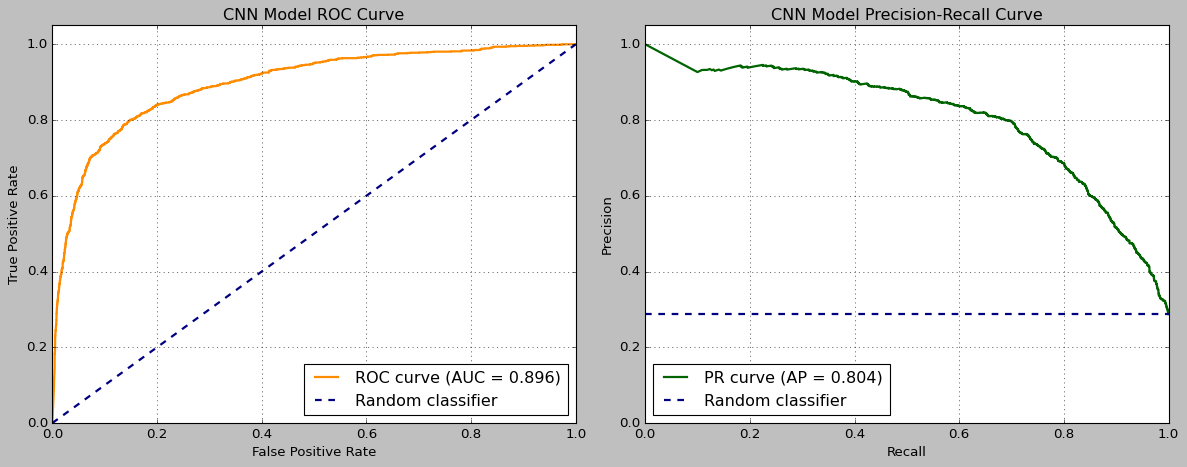

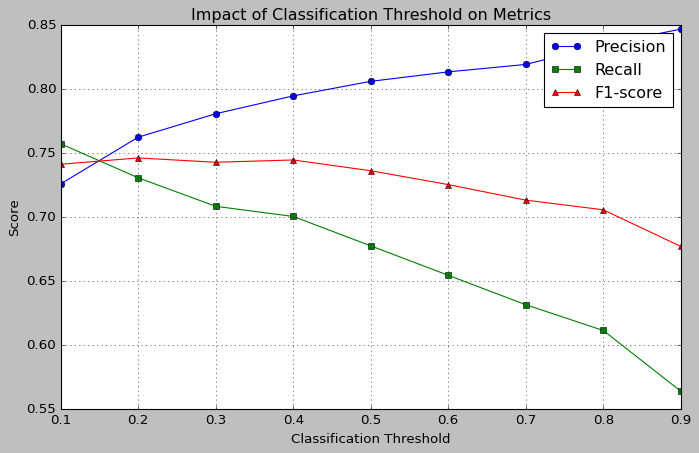


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8962

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8041

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.20
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.726, Recall=0.757, F1=0.741
   Threshold 0.2: Precision=0.762, Recall=0.731, F1=0.746
   Threshold 0.3: Precision=0.781, Recall=0.708, F1=0.743
   Threshold 0.4: Precision=0.795, Recall=0.700, F1=0.745
   Threshold 0.5: Precision=0.806, Recall=0.677, F1=0.736
   Threshold 0.6: Precision=0.813, Recall=0.654, F1=0.725
   Threshold 0.7: Precision=0.819, Recall=0.631, F1=0.713
   Threshold 0.8: Precision=0.834, Recall=0.611, F1=0.706
   Threshold 0.9: Precision=0.847, Recall=0.564, F1=0.677
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Cross-Validation Results:
Accuracy: 0.9321 ± 0.0070
Precision: 0.9246 ± 0.0219
Recall: 0.9420 ± 0.0145
F1: 0.9329 ± 0.0059

Test Set

In [7]:
# smote old run
cv_scores_1a, test_scores_1a, best_rn_model_1a, history_rn_model_1a = kfold_model_performance(
    final_df_ambient, build_model_fn=build_inceptiontime_model, augmentation_fn=apply_smote, 
    window_size=11, step_size=1
)

stratify labels
Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Data after SMOTE: 27978 samples

==================== Training Set After apply_smote ====================
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5
Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.6700 - loss: 0.6076 - val_accuracy: 0.6851 - val_loss: 0.5800
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.7832 - loss: 0.4668 - val_accuracy: 0.7596 - val_loss: 0.4975
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.8275 - loss: 0.3848 - val_accuracy: 0.8197 - val_loss: 0.3983
Epoch 4/100
700/700 ━━

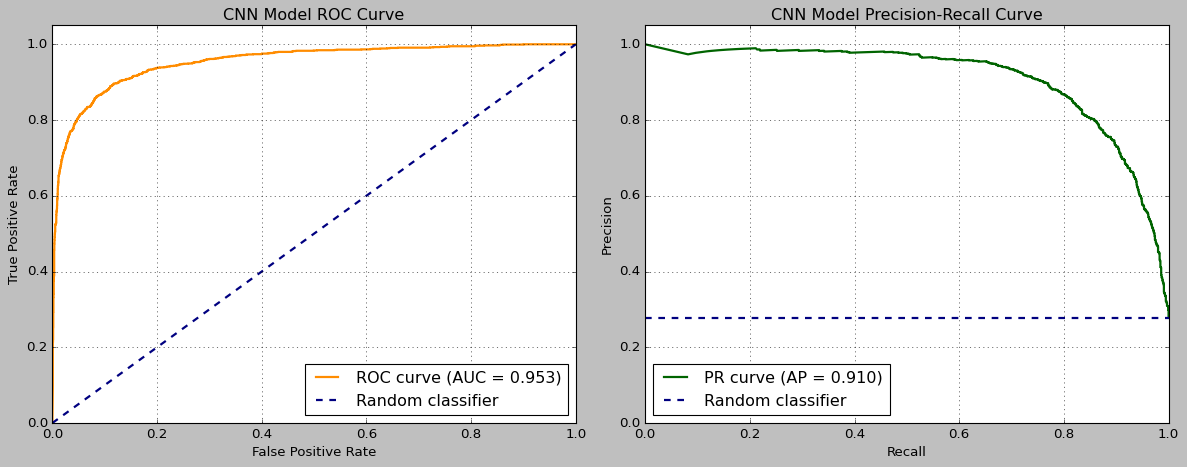

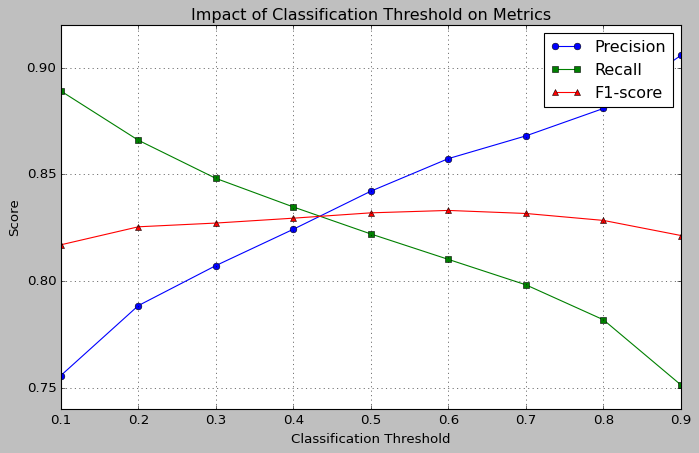


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9535

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.9096

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.60
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.756, Recall=0.889, F1=0.817
   Threshold 0.2: Precision=0.788, Recall=0.866, F1=0.825
   Threshold 0.3: Precision=0.807, Recall=0.848, F1=0.827
   Threshold 0.4: Precision=0.824, Recall=0.835, F1=0.829
   Threshold 0.5: Precision=0.842, Recall=0.822, F1=0.832
   Threshold 0.6: Precision=0.857, Recall=0.810, F1=0.833
   Threshold 0.7: Precision=0.868, Recall=0.798, F1=0.832
   Threshold 0.8: Precision=0.881, Recall=0.782, F1=0.828
   Threshold 0.9: Precision=0.906, Recall=0.751, F1=0.821
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Cross-Validation Results:
Accuracy: 0.9425 ± 0.0095
Precision: 0.9203 ± 0.0222
Recall: 0.9698 ± 0.0078
F1: 0.9441 ± 0.0082

Test Set

In [11]:
# smote new run
cv_scores_1an, test_scores_1an, best_rn_model_1an, history_rn_model_1an = kfold_model_performance(
    final_df_ambient, build_model_fn=build_inceptiontime_model, augmentation_fn=apply_smote, 
    window_size=11, step_size=1
)

stratify labels
Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

==================== Training set: NO Sampling ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

Fold 1/5
Epoch 1/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.7141 - loss: 0.5639 - val_accuracy: 0.7237 - val_loss: 0.6251
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7699 - loss: 0.4938 - val_accuracy: 0.7515 - val_loss: 0.5357
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7949 - loss: 0.4480 - val_accuracy: 0.7712 - val_loss: 0.4889
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accur

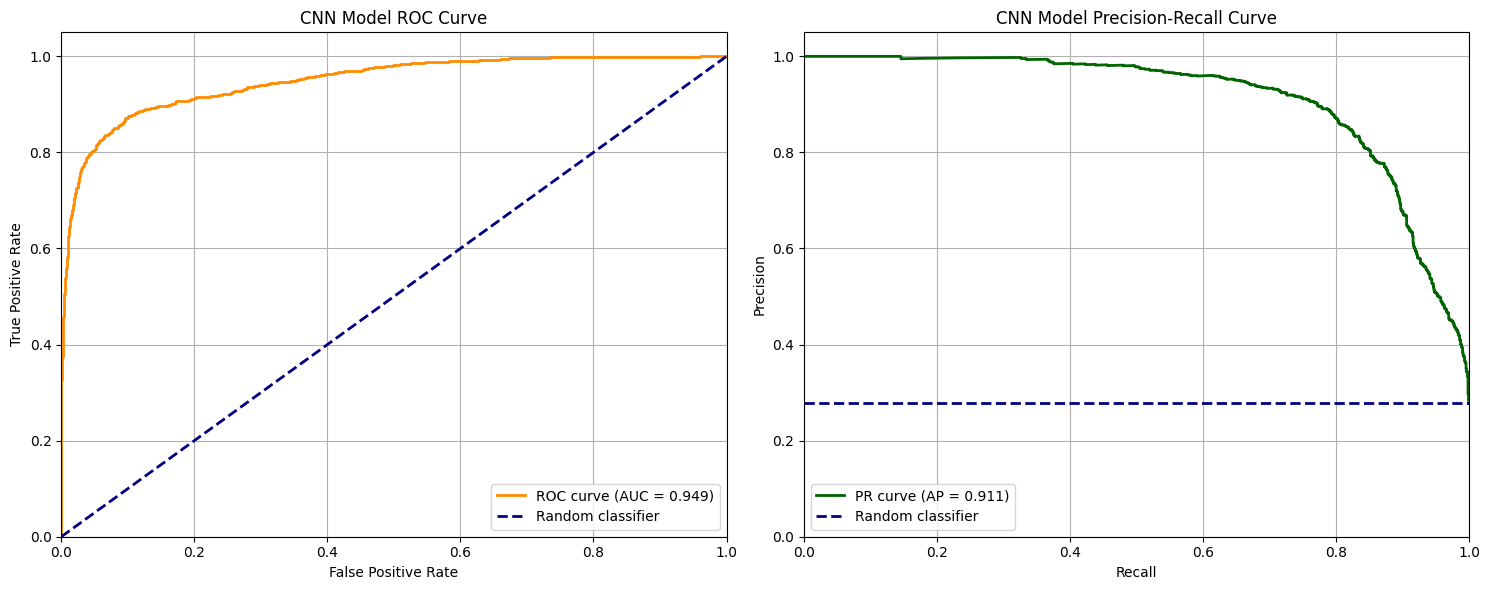

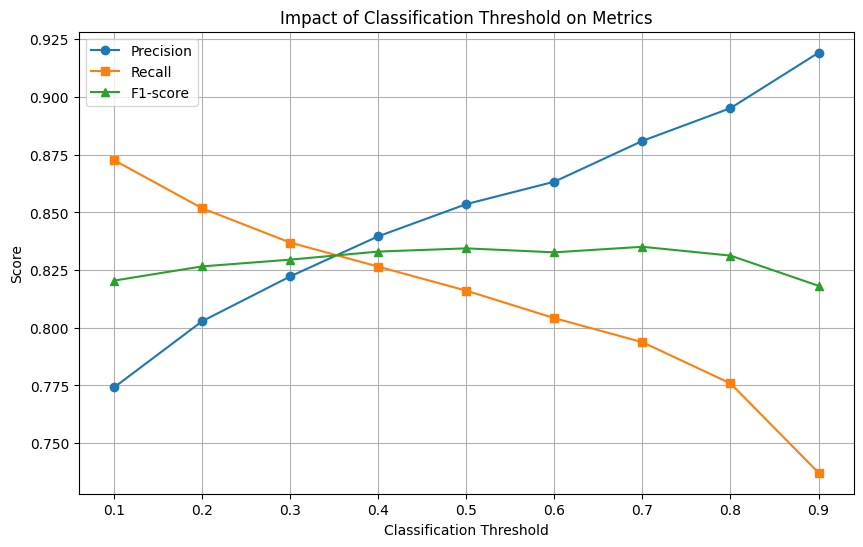


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9485

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.9107

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.70
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.774, Recall=0.873, F1=0.820
   Threshold 0.2: Precision=0.803, Recall=0.852, F1=0.827
   Threshold 0.3: Precision=0.822, Recall=0.837, F1=0.830
   Threshold 0.4: Precision=0.840, Recall=0.827, F1=0.833
   Threshold 0.5: Precision=0.854, Recall=0.816, F1=0.834
   Threshold 0.6: Precision=0.863, Recall=0.804, F1=0.833
   Threshold 0.7: Precision=0.881, Recall=0.794, F1=0.835
   Threshold 0.8: Precision=0.895, Recall=0.776, F1=0.831
   Threshold 0.9: Precision=0.919, Recall=0.737, F1=0.818
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Cross-Validation Results:
Accuracy: 0.9084 ± 0.0077
Precision: 0.8724 ± 0.0540
Recall: 0.7931 ± 0.0567
F1: 0.8273 ± 0.0148

Test Set

In [14]:
# NONE - this laptop
cv_scores_1n, test_scores_1n, best_rn_model_1n, history_rn_model_1n = kfold_model_performance(
    final_df_ambient, build_model_fn=build_inceptiontime_model, augmentation_fn=None, 
    window_size=11, step_size=1
)
# kernel size = 3

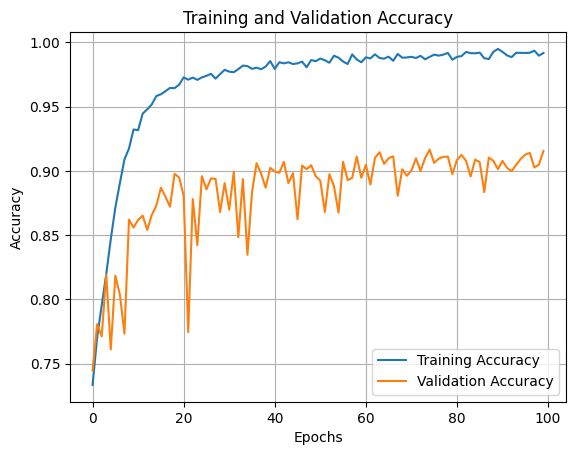

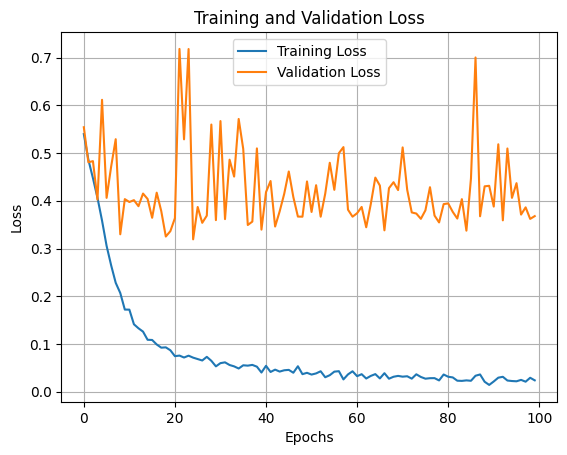

In [15]:
def plot_accuracy(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history_rn_model_1n)
plot_loss(history_rn_model_1n)

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Data after ADASYN: 26965 samples

==================== Training Set After apply_adasyn ====================
Dataset shape: (26965, 11, 9)
Labels shape: (26965,)

Class Distribution:
-----------------
Class 0: 14038 samples (52.06%)
Class 1: 12927 samples (47.94%)

Fold 1/5
Epoch 1/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.6570 - loss: 0.6195 - val_accuracy: 0.6138 - val_loss: 0.8153
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.7691 - loss: 0.4867 - val_accuracy: 0.7499 - val_loss: 0.5307
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.8119 - loss: 0.4089 - val_accuracy: 0.6740 - val_loss: 0.8202
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.8542 - loss: 0.3323 - val_accuracy: 0.8431 - val_loss: 0.3537
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.8814 - loss: 0.2797 - val_accuracy: 0.8103 - val_loss: 0.4886
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.90

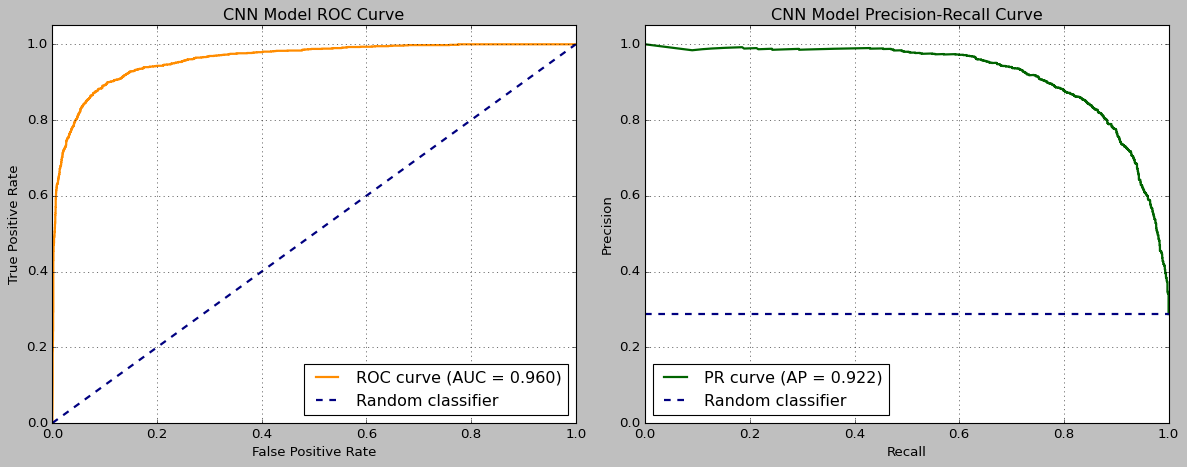

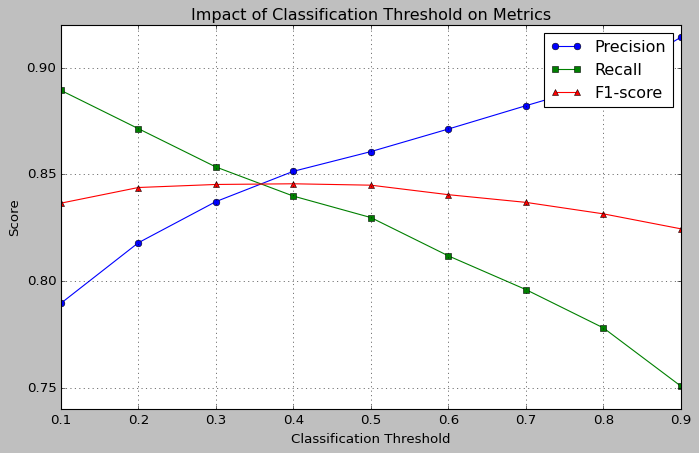


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9599

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.9224

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.790, Recall=0.889, F1=0.836
   Threshold 0.2: Precision=0.818, Recall=0.871, F1=0.844
   Threshold 0.3: Precision=0.837, Recall=0.853, F1=0.845
   Threshold 0.4: Precision=0.851, Recall=0.840, F1=0.846
   Threshold 0.5: Precision=0.861, Recall=0.830, F1=0.845
   Threshold 0.6: Precision=0.871, Recall=0.812, F1=0.840
   Threshold 0.7: Precision=0.882, Recall=0.796, F1=0.837
   Threshold 0.8: Precision=0.893, Recall=0.778, F1=0.831
   Threshold 0.9: Precision=0.914, Recall=0.751, F1=0.824
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Cross-Validation Results:
Accuracy: 0.9503 ± 0.0053
Precision: 0.9455 ± 0.0099
Recall: 0.9513 ± 0.0094
F1: 0.9483 ± 0.0054

Test Set

In [9]:
# adasyn - this laptop
cv_scores_ada, test_scores_ada, best_cnn_model_ada, history_model_ada = kfold_model_performance(
    final_df_ambient, build_model_fn=build_inceptiontime_model, augmentation_fn=apply_adasyn, 
    window_size=11, step_size=1
)

NameError: name 'history_model_ada' is not defined

stratify labels
Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Data after ROS: 27978 samples

==================== Training Set After apply_ros ====================
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5
Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6441 - loss: 0.6324 - val_accuracy: 0.6932 - val_loss: 0.5784
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7458 - loss: 0.5164 - val_accuracy: 0.7732 - val_loss: 0.4681
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.8100 - loss: 0.4159 - val_accuracy: 0.7636 - val_loss: 0.4909
Epoch 4/100
700/700 ━━━━━━

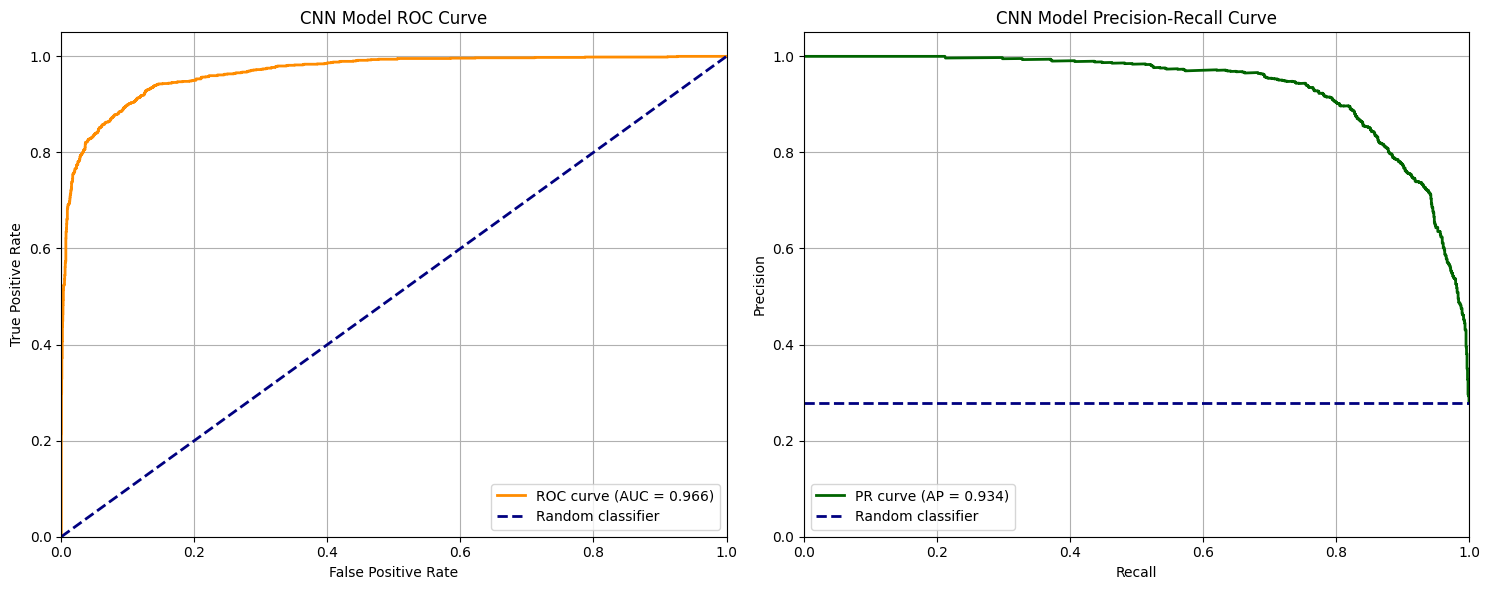

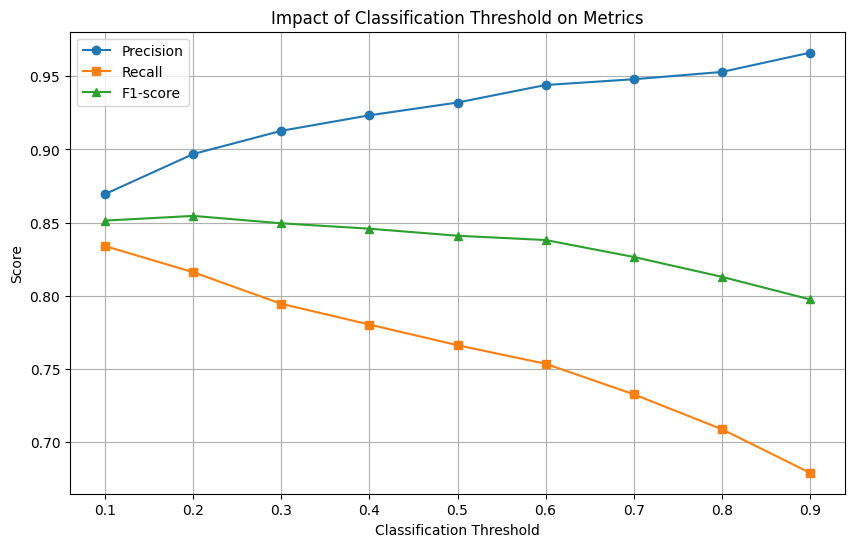


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9660

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.9337

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.20
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.870, Recall=0.834, F1=0.851
   Threshold 0.2: Precision=0.897, Recall=0.816, F1=0.855
   Threshold 0.3: Precision=0.913, Recall=0.794, F1=0.850
   Threshold 0.4: Precision=0.923, Recall=0.780, F1=0.846
   Threshold 0.5: Precision=0.932, Recall=0.766, F1=0.841
   Threshold 0.6: Precision=0.944, Recall=0.754, F1=0.838
   Threshold 0.7: Precision=0.948, Recall=0.733, F1=0.827
   Threshold 0.8: Precision=0.953, Recall=0.709, F1=0.813
   Threshold 0.9: Precision=0.966, Recall=0.679, F1=0.798
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Cross-Validation Results:
Accuracy: 0.9560 ± 0.0106
Precision: 0.9417 ± 0.0267
Recall: 0.9734 ± 0.0096
F1: 0.9569 ± 0.0095

Test Set

In [5]:
cv_scores_ros, test_scores_ros, best_cnn_model_ros, history_model_ros = kfold_model_performance(
    final_df_ambient, build_model_fn=build_inceptiontime_model, augmentation_fn=apply_ros, 
    window_size=11, step_size=1
)


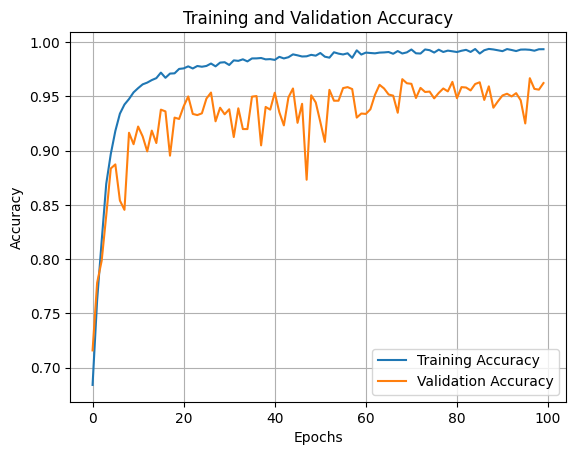

In [6]:

import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_accuracy(history_model_ros)



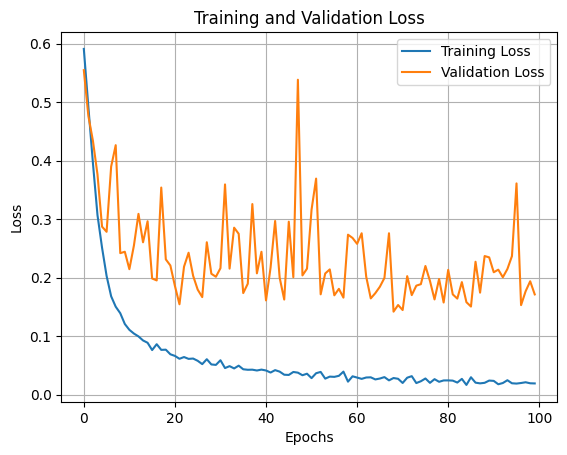

In [7]:
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_loss(history_model_ros)

In [ ]:
# num samples 8716, 100 epochs
def apply_gan_augmentation(X_train, y_train, num_samples=8,716, noise_dim=100, hidden_dim=64, num_epochs=100):
    """
    Generate synthetic time-series data using a GAN and augment the training set.
    
    Parameters:
    - X_train: Original training data (features)
    - y_train: Original training labels
    - num_samples: Number of synthetic sequences to generate
    - noise_dim: Dimensionality of the random noise vector
    - hidden_dim: Hidden layer size for both Generator and Discriminator
    - num_epochs: Number of epochs to train the GAN
    
    Returns:
    - X_augmented: Augmented feature set (X_train + synthetic samples)
    - y_augmented: Augmented labels set (y_train + synthetic labels)
    """

    # Get sequence length from X_train (assume [n_samples, seq_len, features])
    seq_len = X_train.shape[1]
    feature_dim = X_train.shape[2]

    # Define the Generator
    class Generator(nn.Module):
        def __init__(self, noise_dim, hidden_dim, output_dim):
            super(Generator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(noise_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )

        def forward(self, noise):
            return self.model(noise)

    # Define the Discriminator
    class Discriminator(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Discriminator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim, 1),
                nn.Sigmoid()
            )

        def forward(self, data):
            return self.model(data)

    # Initialize the Generator and Discriminator
    generator = Generator(noise_dim, hidden_dim, seq_len * feature_dim)
    discriminator = Discriminator(seq_len * feature_dim, hidden_dim)

    # Optimizers and loss function
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    # Function to generate random noise
    def generate_noise(batch_size, noise_dim):
        return torch.randn(batch_size, noise_dim)

    # Train the GAN
    batch_size = 32
    for epoch in range(num_epochs):
        # === Train Discriminator ===
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = torch.tensor(X_train[idx].reshape(batch_size, -1), dtype=torch.float32)
        fake_data = generator(generate_noise(batch_size, noise_dim)).detach()

        # Discriminator loss
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        d_loss_real = criterion(discriminator(real_data), real_labels)
        d_loss_fake = criterion(discriminator(fake_data), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Backprop for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        noise = generate_noise(batch_size, noise_dim)
        generated_data = generator(noise)

        g_loss = criterion(discriminator(generated_data), real_labels)  # Fool the discriminator

        # Backprop for Generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Generate synthetic data
    noise = generate_noise(num_samples, noise_dim)
    synthetic_data = generator(noise).detach().numpy()
    synthetic_data = synthetic_data.reshape(num_samples, seq_len, feature_dim)

    # Create synthetic labels (1 for falls or any minority class, as needed)
    synthetic_labels = np.ones(num_samples)

    # Concatenate synthetic data with original training data
    X_augmented = np.concatenate((X_train, synthetic_data), axis=0)
    y_augmented = np.concatenate((y_train, synthetic_labels), axis=0)

    return X_augmented, y_augmented

cv_scores_n, test_scores_n, best_cnn_model_n, history_model_n = kfold_model_performance(
    final_df_ambient, build_model_fn=build_inceptiontime_model, 
    augmentation_fn=None, gan_fn=apply_gan_augmentation, 
    window_size=11, step_size=1
)

In [5]:
# import tensorflow as tf 
# def build_lstm_model_l2(input_shape, optimizer='adam', units=64, learning_rate=0.001, l2_lambda=0.00001):
#     model = Sequential([
#         tf.keras.Input(shape=input_shape),
#         LSTM(units, activation='tanh', return_sequences=False,
#              kernel_regularizer=l2(l2_lambda),
#              recurrent_regularizer=l2(l2_lambda),
#              bias_regularizer=l2(l2_lambda)),
#         Dense(64, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])


#     opt = Adam(learning_rate=learning_rate)
#     # elif optimizer == 'rmsprop':
#     #     opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

#     model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#     return model


# cv_scores_lstm, test_scores_lstm, best_cnn_model_lstm, history_model_lstm = kfold_model_performance(
#     final_df_ambient, build_model_fn=build_lstm_model_l2, augmentation_fn=apply_adasyn, 
#     window_size=11, step_size=1
# )

stratify labels
Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Data after ADASYN: 26919 samples

==================== Training Set After apply_adasyn ====================
Dataset shape: (26919, 11, 9)
Labels shape: (26919,)

Class Distribution:
-----------------
Class 0: 13989 samples (51.97%)
Class 1: 12930 samples (48.03%)

Fold 1/5
Epoch 1/100
673/673 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5761 - loss: 0.6778 - val_accuracy: 0.6321 - val_loss: 0.6451
Epoch 2/100
673/673 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6291 - loss: 0.6413 - val_accuracy: 0.6568 - val_loss: 0.6202
Epoch 3/100
673/673 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6548 - loss: 0.6168 - val_accuracy: 0.6751 - val_loss: 0.6063
Epoch 4/100
673/673 ━━

KeyboardInterrupt: 